In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt

from dispersant_screener.utils import get_maxmin_samples, get_hypervolume, read_pickle, get_random_exploration_bl, is_pareto_efficient
from dispersant_screener.definitions import FEATURES
from sklearn.preprocessing import StandardScaler
from glob import glob 
import os

DATADIR = '../data'
from functools import partial
from matplotlib import animation, rc

COLORS = [
    "#ffbe0b", 
    "#fb5607", 
    "#ff006e",
    "#3a86ff", 
]

plt.rcParams['font.family'] = 'sans-serif'

In [25]:
discarded = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-discarded.npy', allow_pickle=True)
unclassified = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-unclassified.npy', allow_pickle=True)
pareto_optimal = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-pareto_optimal_indices.npy', allow_pickle=True)
selected = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-selected.npy', allow_pickle=True)

greedy_indices = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-greedy_indices.npy', allow_pickle=True)

In [26]:
discarded1 = np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-discarded.npy', allow_pickle=True)
unclassified1 = np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-unclassified.npy', allow_pickle=True)
pareto_optimal1 = np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-pareto_optimal_indices.npy', allow_pickle=True)
selected1 = np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-selected.npy', allow_pickle=True)

greedy_indices1 = np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-greedy_indices.npy', allow_pickle=True)

In [27]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(df_full_factorial_feat)

    if label_scaling:
        label_scaler = MinMaxScaler()
        y = label_scaler.fit_transform(y)

    #greedy_indices = get_maxmin_samples(X, n_samples)

    return X, y#, greedy_indice

In [28]:
X, y = load_data(1)

In [29]:
hvs = list(np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-hypervolumes.npy', allow_pickle=True))
hvs1 = list(np.load('../work/sweeps3/20201021-235927_dispersant_0.05_0.05_0.05_60-hypervolumes.npy', allow_pickle=True))

In [30]:
hvs_padded = np.array([get_hypervolume(y[greedy_indices], [5,5,5])] * 60 + hvs)
hvs_padded = np.array([max([v, hvs_padded[0]]) for v in hvs_padded])

In [31]:
def get_summary_stats_time(pareto_optimal=pareto_optimal, discarded=discarded, selected=selected, unclassified=unclassified): 
    pareto_points = []
    non_pareto_points = []
    sampled_points = []
    unclassified_points = []
    
    for array in pareto_optimal:
        pareto_points.append(len(array))
        
    for array in discarded:
        non_pareto_points.append(len(array))
    
    for array in selected:
        sampled_points.append(len(array))
        
    for array in unclassified: 
        unclassified_points.append(len(array))
    
    return pareto_points, non_pareto_points, sampled_points, unclassified_points

In [32]:
pareto_points, non_pareto_points, sampled_points, unclassified_points = get_summary_stats_time()

In [33]:
pareto_points1, non_pareto_points1, sampled_points1, unclassified_points1 = get_summary_stats_time(
    pareto_optimal1, discarded1, selected1, unclassified1
)

In [34]:
REFERENCE_HV = get_hypervolume(y, [5,5,5])

In [12]:
# def get_settings_from_filename(filename):
#     parts = filename.split('_')

#     alpha_parts = parts[0].split('.')
#     decimal = alpha_parts[-1]
#     full_part = alpha_parts[0][-1]
#     alpha = float(f'{full_part}.{decimal}')

#     delta = float(parts[1])
#     beta_scale = float(parts[2])
#     n_samples = int(parts[3].split('-')[0])
#     data_type = parts[3].split('-')[-1].split('.')[0]
    
    
#     return { 
#         'name': filename, 
#         'alpha': alpha, 
#         'delta': delta, 
#         'beta_scale': beta_scale,
#         'n_samples': n_samples, 
#         'data_type': data_type
#     }

# all_hv_files = glob('work/sweep2/*-hypervolumes.npy')

# results = []
# for file in all_hv_files: 
#     meta = get_settings_from_filename(file)
#     hv = np.load(file)
    
#     error = (REFERENCE_HV-hv[-1])/REFERENCE_HV
    
#     meta['error'] = error * 100
#     meta['iterations'] = len(hv)
    
#     results.append(meta)
    
# df = pd.DataFrame(results)

# df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][3]) & (df['delta']==0.01)].sort_values(by='error')

# fig, ax = plt.subplots(1,1)

# subset0 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][3]) & (df['delta']==0.05)].sort_values(by='error')
# subset1 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][2]) & (df['delta']==0.05)].sort_values(by='error')
# subset2 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][2]) & (df['delta']==0.01) & (df['alpha']>0)].sort_values(by='error')

# ax.plot(subset0['alpha'] * 100, subset0['error'], label=r'60 initial samples, $\delta=0.05$, $\beta_\mathrm{scale}=1/9$')
# ax.plot(subset1['alpha'] * 100, subset1['error'], label=r'60 initial samples, $\delta=0.05$, $\beta_\mathrm{scale}=1/16$')
# ax.plot(subset2['alpha'] * 100, subset2['error'], label=r'60 initial samples, $\delta=0.01$, $\beta_\mathrm{scale}=1/16$')

# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['left'].set_smart_bounds(True)
# ax.spines['bottom'].set_smart_bounds(True)


# ax.set_xlabel(r'$100\ \epsilon$')
# ax.set_ylabel(r'hypervolume error')
# ax.legend()

# fig.tight_layout()
# fig.savefig('some_parameter_settings.pdf', bbox_inches='tight')

In [48]:
hvs_missing = np.load('missing_data_hv.npy')
hvs_missing0 = np.load('missing_data_hv0.npy')

In [36]:
np.where((REFERENCE_HV-np.array(hvs1))/REFERENCE_HV * 100 <= 5)

(array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]),)

In [37]:
np.where((REFERENCE_HV-np.array(random_exploration_median))/REFERENCE_HV * 100 <= 5)

(array([ 509,  510,  511, ..., 3122, 3123, 3124]),)

In [38]:
len(y)

3125

In [39]:
random_explorations = np.load('random_exploration_60_init.npy')

In [40]:
# random_explorations = []

# for i in range(100):
#     hv_random = get_random_exploration_bl(y, reference_vector=[5,5,5], init_points=greedy_indices)
#     random_explorations.append(hv_random)
# np.save('random_exploration_60_init.npy', random_explorations)

In [43]:
random_exploration_median = np.median(random_explorations, axis=0)
random_exploration_std = np.std(random_explorations, axis=0)

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two mi

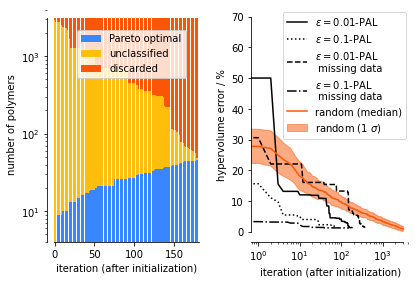

In [49]:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1]})

ax[0].bar(range(len(pareto_optimal)), 
          pareto_points,
          label='Pareto optimal', color=COLORS[3])
ax[0].bar(range(len(pareto_optimal)), unclassified_points, bottom=np.array(pareto_points), 
          label='unclassified', color=COLORS[0])
ax[0].bar(range(len(pareto_optimal)), non_pareto_points, 
          bottom=unclassified_points+np.array(pareto_points), label='discarded', color=COLORS[1])



ax[0].set_xlabel('iteration (after initialization)')
ax[1].set_xlabel('iteration (after initialization)')
ax[0].set_ylabel('number of polymers')
ax[1].set_ylabel('hypervolume error / %')

ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].plot((REFERENCE_HV-np.array(hvs))/REFERENCE_HV * 100, label=r'$\epsilon=0.01$-PAL', c='black')
ax[1].plot((REFERENCE_HV-np.array(hvs1))/REFERENCE_HV * 100, label=r'$\epsilon=0.1$-PAL', c='black', ls='dotted')

ax[1].plot((REFERENCE_HV-np.array(hvs_missing0))/REFERENCE_HV * 100, label=r"$\epsilon=0.01$-PAL" +"\n missing data", c='black', ls='dashed')
ax[1].plot((REFERENCE_HV-np.array(hvs_missing))/REFERENCE_HV * 100, label=r"$\epsilon=0.1$-PAL" +"\n missing data", c='black', ls='dashdot')


ax[1].plot((REFERENCE_HV-np.array(random_exploration_median))/REFERENCE_HV * 100, 
           label='random (median)', c=COLORS[1])
ax[1].fill_between(np.arange(len(y)),
                   (REFERENCE_HV-np.array(random_exploration_median + random_exploration_std))/REFERENCE_HV * 100, (REFERENCE_HV-np.array(random_exploration_median - random_exploration_std))/REFERENCE_HV * 100, 
                   label=r'random (1 $\sigma$)', color=COLORS[1], alpha=.5)
#ax[1].plot(ratios)
ax[1].legend(loc='upper right', bbox_to_anchor=(1,1))

fig.tight_layout()

ax[1].set_xscale('log')
ax[0].set_yscale('log')

ax[0].legend(loc='right', bbox_to_anchor=(0.9,0.8))


fig.savefig('palplot_final.pdf', bbox_inches='tight')

In [52]:
pareto_indices_classified = is_pareto_efficient(-y[pareto_optimal[-1]])

In [53]:
pareto_true_indices = is_pareto_efficient(-y)

In [54]:
import matplotlib.ticker as plticker

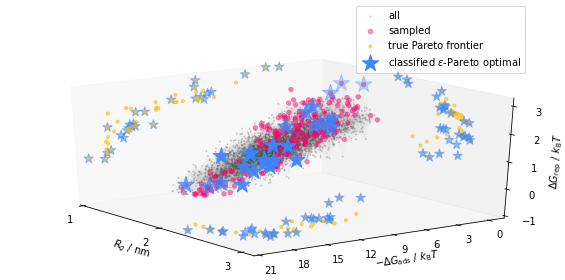

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y[:,0], y[:,1], y[:,2], alpha=.3, s=1, c='gray',  label='all')
ax.plot_trisurf(y[:,0], y[:,1], y[:,2], color='gray', shade=True, 
                linewidth=0.01, edgecolor='none', alpha=.01)
ax.scatter(y[selected[-1],0], y[selected[-1],1], y[selected[-1],2], s=20, alpha=.4, label='sampled', c=COLORS[2])


# True pareto frontier 
ax.scatter([1.0] * len(y[pareto_true_indices,0]), y[pareto_true_indices,1], y[pareto_true_indices,2], c=COLORS[0], 
            label='true Pareto frontier', s=10, marker='o', alpha=.6)
ax.scatter(y[pareto_true_indices, 0], [-1] * len(y[pareto_true_indices, 1]), y[pareto_true_indices,2], c=COLORS[0], 
            label='_nolegend_', s=10, marker='o', alpha=.6)
ax.scatter(y[pareto_true_indices,0], y[pareto_true_indices,1], [-1] * len(y[pareto_true_indices,2]), c=COLORS[0], 
            label='_nolegend_', s=10, marker='o', alpha=.6)


# e-PAL recovered
ax.scatter([1.0]*len(y[pareto_optimal[-1],0][pareto_indices_classified]), 
           y[pareto_optimal[-1],1][pareto_indices_classified],
           y[pareto_optimal[-1],2][pareto_indices_classified], 
           s=100, label='_nolegend_', c=COLORS[3],  marker='*', alpha=.5)

ax.scatter(y[pareto_optimal[-1],0][pareto_indices_classified],
           y[pareto_optimal[-1],1][pareto_indices_classified], 
           [-1.0] * len(y[pareto_optimal[-1],2][pareto_indices_classified]), 
           s=100, label='_nolegend_', c=COLORS[3],  marker='*', alpha=.5)

ax.scatter(y[pareto_optimal[-1],0][pareto_indices_classified],
           [-1] * len(y[pareto_optimal[-1],1][pareto_indices_classified]), 
           y[pareto_optimal[-1],2][pareto_indices_classified], 
           s=100, label='_nolegend_', c=COLORS[3], marker='*', alpha=.5)


# all Pareto classified 
ax.scatter(y[pareto_optimal[-1],0][pareto_indices_classified], 
           y[pareto_optimal[-1],1][pareto_indices_classified], 
           y[pareto_optimal[-1],2][pareto_indices_classified],s=300, c=COLORS[3],
           label='classified $\epsilon$-Pareto optimal',  marker='*')


# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')

ax.view_init(205, 216)
ax.legend(loc='center right', bbox_to_anchor=(0.95,1))
ax.grid(False)
ax.set_zlim(3.2, -1.0)
ax.set_xlim(1.0, 3.1)
ax.set_ylim(-1, 21)

ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=3.0))
ax.zaxis.set_major_locator(plticker.MultipleLocator(base=1.0))

ax.set_xlabel(r'$R_g$ / nm', labelpad=5)
ax.set_ylabel(r'$-\Delta G_\mathrm{ads}$ / $k_\mathrm{B}T$', labelpad=5)
ax.set_zlabel(r'$\Delta G_\mathrm{rep}$ / $k_\mathrm{B}T$', labelpad=1)

fig.tight_layout()
plt.gcf().subplots_adjust(right=1.3)


fig.savefig('3d_pareto_trisurf_new.pdf', bbox_inches='tight')

In [231]:
full_random = pd.read_csv('../data/X_full_random.csv')

In [243]:
full_random[y[:,1] == y[:,1].max()]['smiles'].values

array(['[Ta][R][Tr][Ta][Ta][Tr][W][Ta][W][Ta][R][Ta][Tr][Tr][R][Ta][Tr][W][Tr][Ta][R][R][Tr][W][R][Tr][R][R][R][R][R][Ta][Tr][Ta][Tr][Tr][R][Ta][Tr][Ta]'],
      dtype=object)